In [15]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

sys.path.append('../')

from src.emotion.analysis.data_preprocessing import (
    DataPreprocessor,
    LinearInterpolator,
    RollingAverageSmoother,
)

from src.emotion.analysis.feature_generator import FeatureGenerator, MaxEmotionGenerator

%matplotlib inline

In [16]:
folder = '/home/moritz/Workspace/masterthesis/data/identities/'
df = pd.read_csv(folder + 'team_20/2023-01-10/team_20_2023-01-10.csv')

In [17]:
emotions = ["Angry", "Disgust", "Happy", "Sad", "Surprise", "Fear", "Neutral"]

In [18]:
preprocessing_pipeline = [
    LinearInterpolator(),
    RollingAverageSmoother(
        window_size=1500,
        cols=emotions,
    ),
]

preprocessor = DataPreprocessor(preprocessing_pipeline)
pre_df = preprocessor.preprocess_data(df)

pre_df.head()

,Frame,Confidence,x_center,y_center,Angry,Disgust,Happy,Sad,Surprise,Fear,Neutral,Brightness,ClassID
0,0,0.888322,963.261841,609.813171,0.023968,0.013228,0.175740,0.045136,0.090784,0.009917,0.641228,139.656602,person_id1
1,5,0.888996,975.549072,616.918701,0.023943,0.013213,0.175525,0.045087,0.090701,0.009904,0.641627,140.160465,person_id1
2,10,0.858353,1011.880005,632.941284,0.023919,0.013196,0.175294,0.045030,0.090648,0.009891,0.642022,140.381493,person_id1
3,15,0.839160,1029.355957,625.232300,0.023893,0.013179,0.175063,0.044977,0.090551,0.009878,0.642460,141.136083,person_id1
4,20,0.844532,1031.143921,624.424683,0.023874,0.013237,0.174844,0.045013,0.090815,0.009875,0.642342,141.495661,person_id1


In [19]:
feature_pipeline = [MaxEmotionGenerator()]

feature_generator = FeatureGenerator(feature_pipeline)
pre_df = feature_generator.generate_features(pre_df)

pre_df.head()

,Frame,Confidence,x_center,y_center,Angry,Disgust,Happy,Sad,Surprise,Fear,Neutral,Brightness,ClassID,Max_Emotion
0,0,0.888322,963.261841,609.813171,0.023968,0.013228,0.175740,0.045136,0.090784,0.009917,0.641228,139.656602,person_id1,Neutral
1,5,0.888996,975.549072,616.918701,0.023943,0.013213,0.175525,0.045087,0.090701,0.009904,0.641627,140.160465,person_id1,Neutral
2,10,0.858353,1011.880005,632.941284,0.023919,0.013196,0.175294,0.045030,0.090648,0.009891,0.642022,140.381493,person_id1,Neutral
3,15,0.839160,1029.355957,625.232300,0.023893,0.013179,0.175063,0.044977,0.090551,0.009878,0.642460,141.136083,person_id1,Neutral
4,20,0.844532,1031.143921,624.424683,0.023874,0.013237,0.174844,0.045013,0.090815,0.009875,0.642342,141.495661,person_id1,Neutral


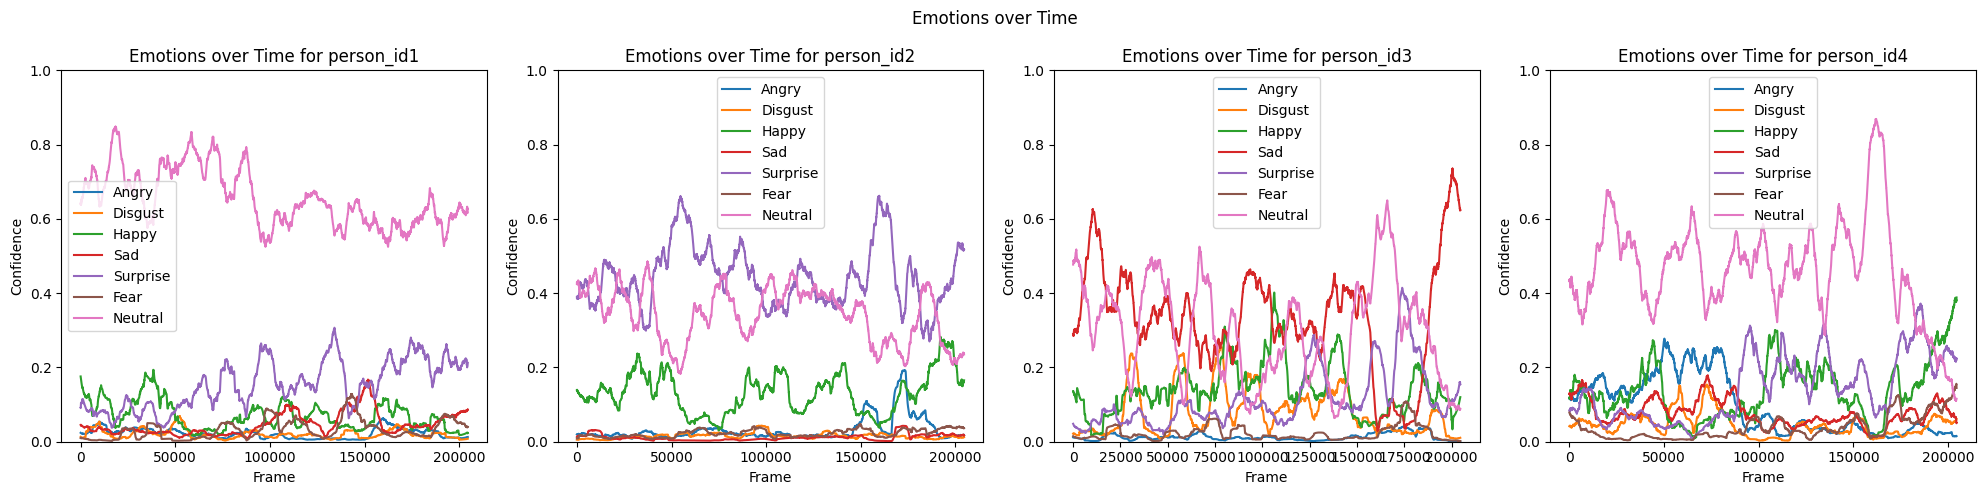

In [20]:
grouped = pre_df.groupby("ClassID")

fig = plt.figure(figsize=(20, 5), tight_layout=True)
fig.suptitle("Emotions over Time")

for i, (person_id, group) in enumerate(grouped):
    emotions_rolling = group[
        [
            "Frame",
            *emotions
        ]
    ]

    ax = fig.add_subplot(1, 4, i + 1)
    emotions_rolling.plot(
        x="Frame",
        y=emotions,
        ax=ax,
    )

    ax.set_title(f"Emotions over Time for {person_id}")
    ax.set_xlabel("Frame")
    ax.set_ylabel("Confidence")
    ax.set_ylim(0, 1)

plt.show()

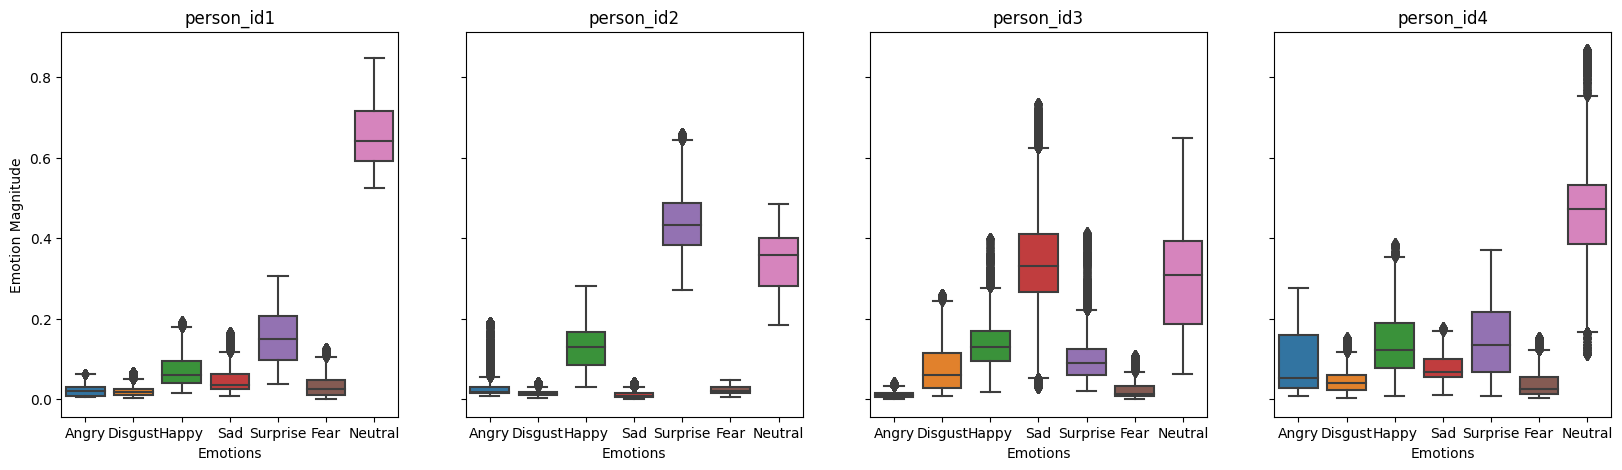

In [21]:
# Set the figure size
fig, axes = plt.subplots(1, len(pre_df['ClassID'].unique()), figsize=(20, 5), sharey=True)

# Loop over each ClassID and plot a boxplot for each emotion
for i, cid in enumerate(pre_df['ClassID'].unique()):
    # Subset the data for the current ClassID
    subset = pre_df[pre_df['ClassID'] == cid][emotions]
    # Plot the boxplot for each emotion on a separate subplot
    sns.boxplot(data=subset, ax=axes[i])
    axes[i].set_title(f'{cid}')
    axes[i].set_xlabel('Emotions')

# Set the y-axis label on the first subplot only
axes[0].set_ylabel('Emotion Magnitude')

# Show the plot
plt.show()

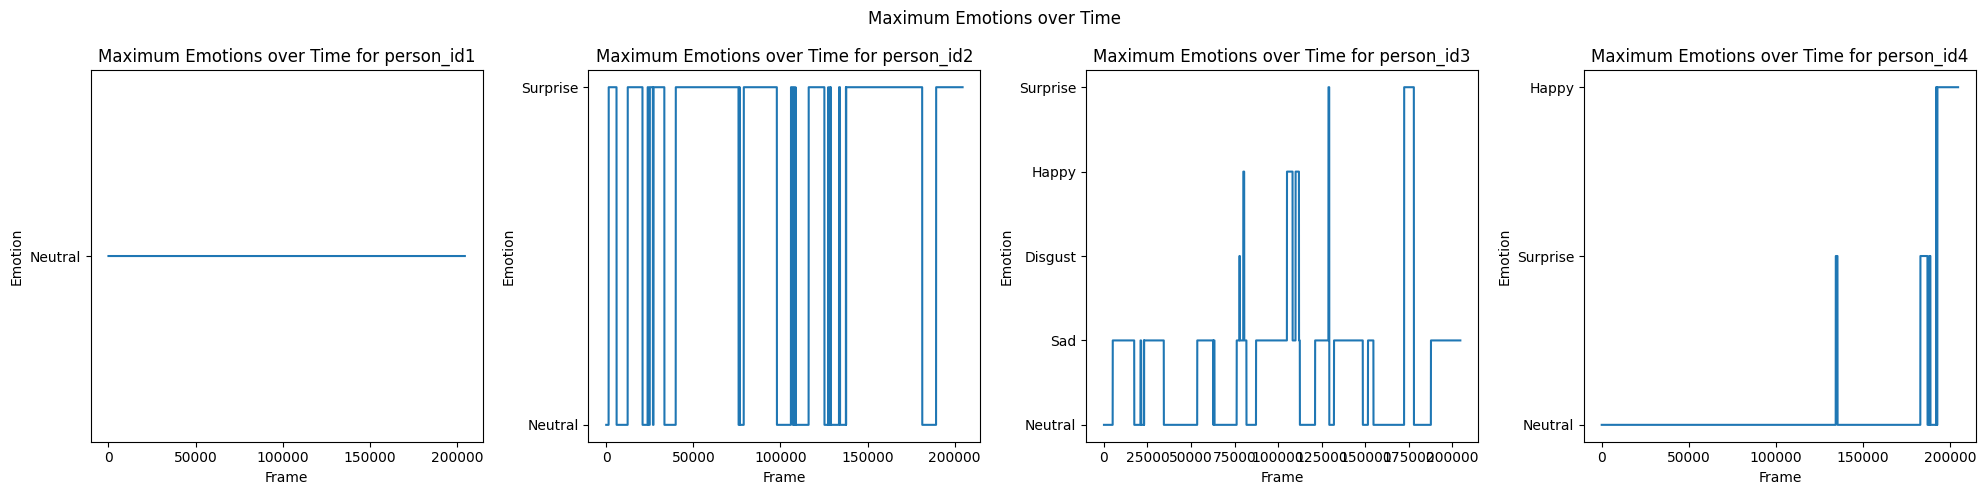

In [22]:
grouped = pre_df.groupby("ClassID")

fig = plt.figure(figsize=(20, 5), tight_layout=True)
fig.suptitle("Maximum Emotions over Time")

for i, (person_id, group) in enumerate(grouped):
    # Get the maximum emotion for each frame
    #person_max_emotion = group[emotions].idxmax(axis=1)

    ax = fig.add_subplot(1, 4, i + 1)
    # Plot the maximum emotion over the frame
    ax.plot(group["Frame"], group["Max_Emotion"])
    ax.set_title(f"Maximum Emotions over Time for {person_id}")
    ax.set_xlabel("Frame")
    ax.set_ylabel("Emotion")

plt.show()

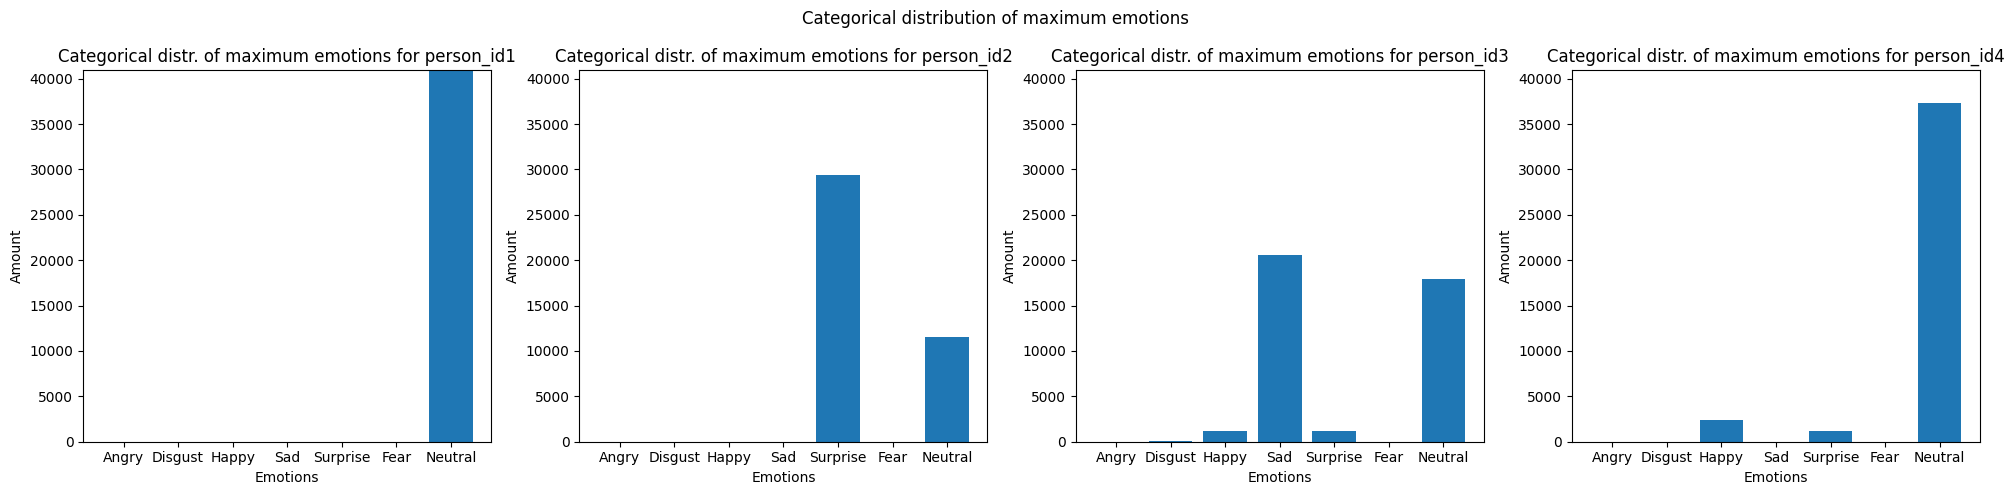

In [23]:
# Find the maximum emotion for each ClassID by selecting the column with the maximum value
pre_df["Max_Emotion"] = pre_df[emotions].idxmax(axis=1)

grouped = pre_df.groupby("ClassID")
max_length_group_index = grouped.size().idxmax()
y_lim = len(grouped.get_group(max_length_group_index))

fig = plt.figure(figsize=(20, 5), tight_layout=True)
fig.suptitle("Categorical distribution of maximum emotions")

for i, (ClassID, group) in enumerate(grouped):

    # Group the data by ClassID and calculate the count of each emotion for each person
    grouped = group.groupby("Max_Emotion").size().reset_index(name="counts")

    ax = fig.add_subplot(1, 4, i + 1)

    # Plot the pivot table as a bar plot
    plt.bar(
        emotions,
        [
            grouped.loc[grouped["Max_Emotion"] == emotion, "counts"].iloc[0]
            if emotion in grouped["Max_Emotion"].values
            else 0
            for emotion in emotions
        ],
    )
    ax.set_title(f"Categorical distr. of maximum emotions for {ClassID}")
    ax.set_xlabel("Emotions")
    ax.set_ylabel("Amount")
    ax.set_ylim(0, y_lim)

plt.show()

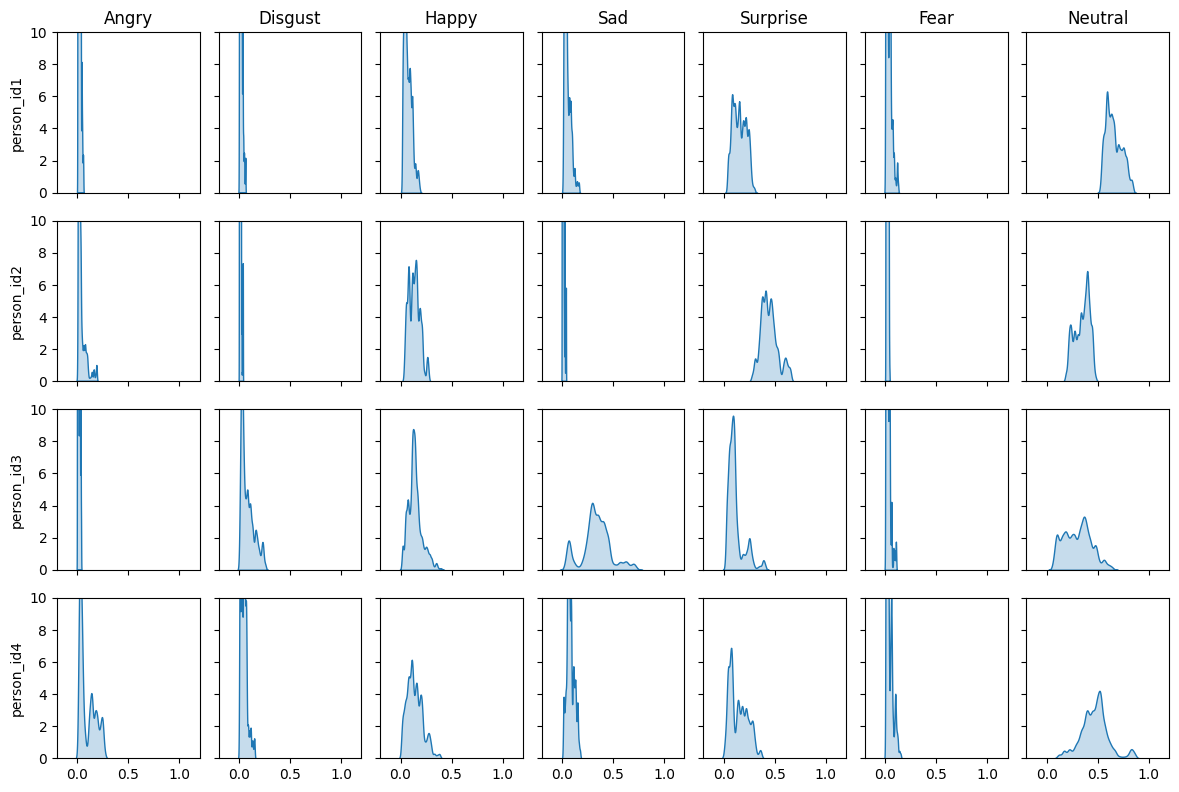

In [24]:
# Group the data by ClassID and emotion columns
grouped = pre_df.groupby(['ClassID', *emotions]).size().reset_index(name='count')

# Define the size of the figure and the number of rows and columns
fig, axes = plt.subplots(nrows=len(grouped['ClassID'].unique()), ncols=len(emotions), figsize=(12, 8), sharex=True, sharey=True)

# Set the x and y axis limits
xlim = (-0.2, 1.2)
ylim = (0, 10)

# Loop over each ClassID and emotion, and plot a distribution plot
for i, cid in enumerate(grouped['ClassID'].unique()):
    for j, e in enumerate(emotions):
        sns.kdeplot(data=grouped[(grouped['ClassID'] == cid)], x=e, ax=axes[i, j], fill=True)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel(f'{cid}')
        if i == 0:
            axes[i, j].set_title(f'{e}')
        axes[i, j].set_xlim(xlim)
        axes[i, j].set_ylim(ylim)

# Adjust the spacing between subplots
fig.tight_layout(pad=1)
plt.show()

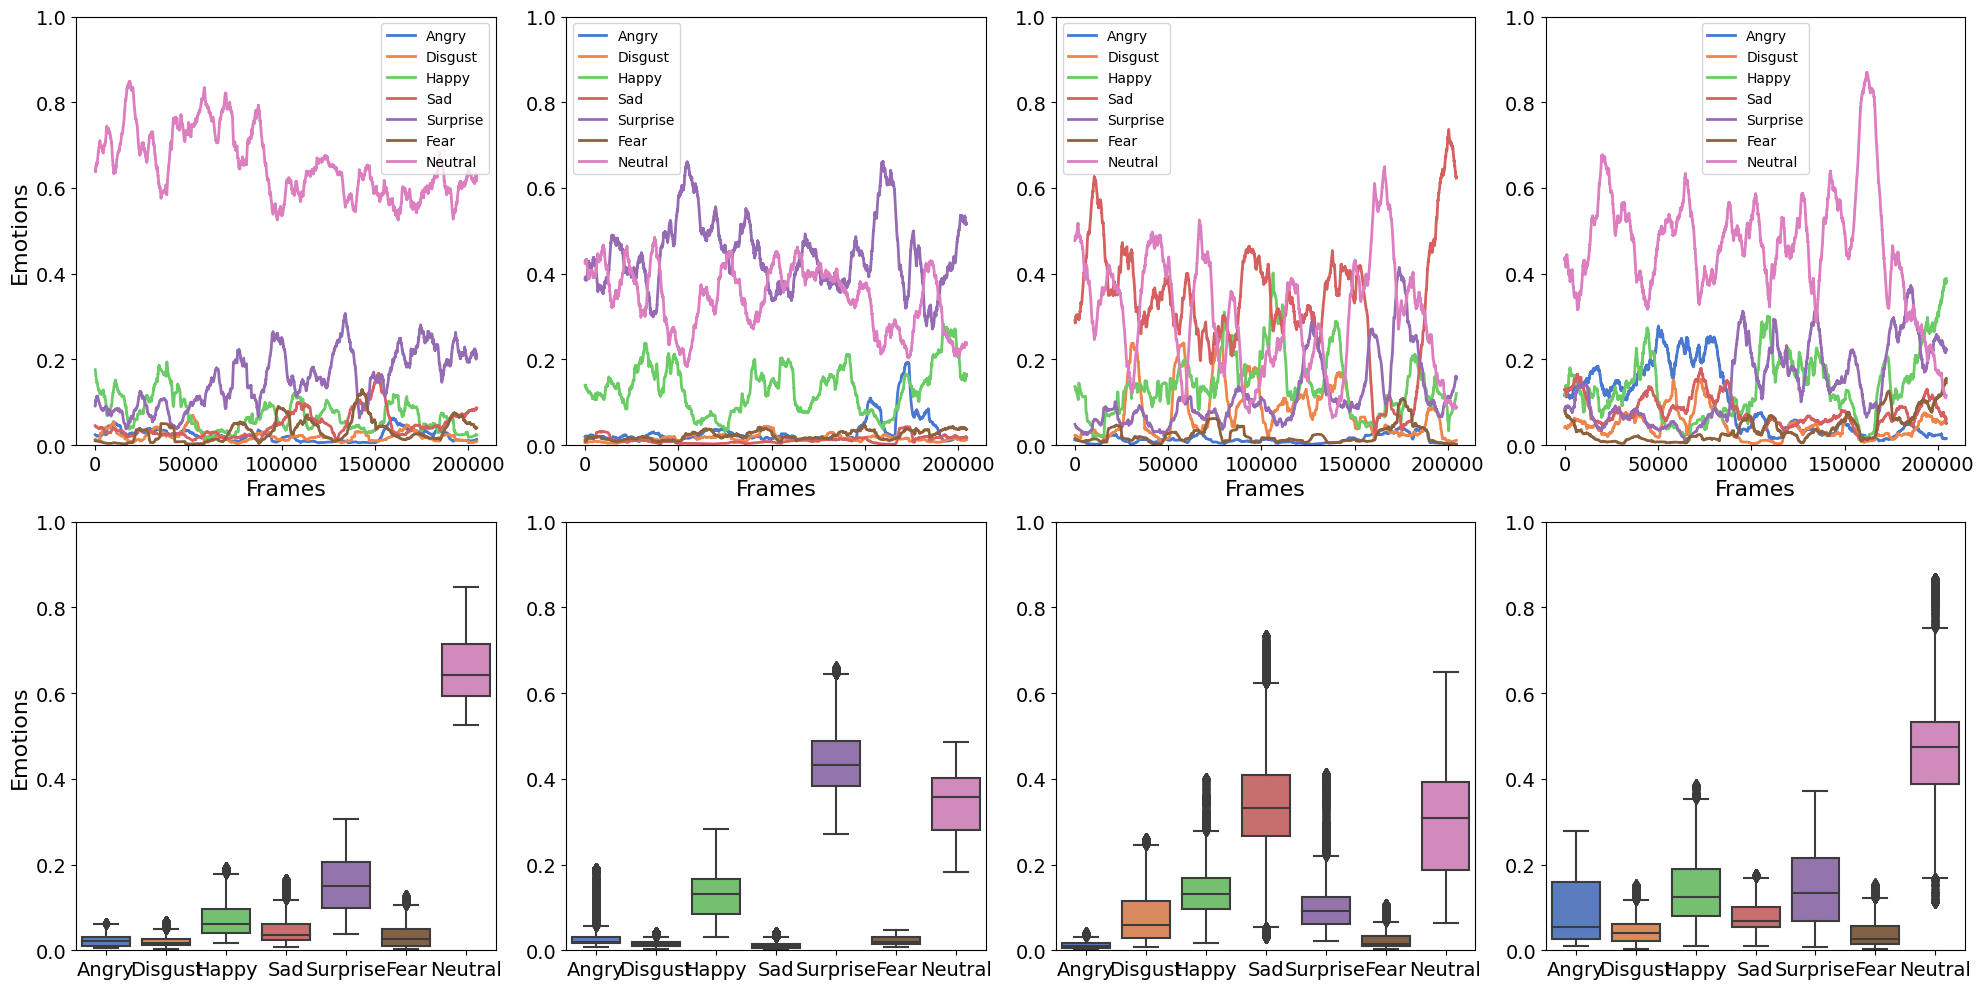

In [33]:
grouped = pre_df.groupby("ClassID")
class_ids = pre_df['ClassID'].unique()

fig = plt.figure(figsize=(20, 10), tight_layout=True)

gs = gridspec.GridSpec(2, len(class_ids), height_ratios=[1, 1])

# Create a custom color palette
palette = sns.color_palette("muted", n_colors=len(emotions))

# Set font sizes
title_font_size = 16
label_font_size = 16
tick_font_size = 14
line_width = 2

for i, cid in enumerate(class_ids):
    group = grouped.get_group(cid)
    emotions_rolling = group[["Frame", *emotions]]

    # Emotions over time plot (upper half)
    ax1 = plt.subplot(gs[0, i])
    emotions_rolling.plot(x="Frame", y=emotions, ax=ax1, color=palette, linewidth=line_width)

    ax1.set_xlabel("Frames", fontsize=label_font_size)
    ax1.tick_params(axis='both', which='major', labelsize=tick_font_size)
    if i == 0:
        ax1.set_ylabel("Emotions", fontsize=label_font_size)
    ax1.set_ylim(0, 1)

    # Emotion magnitude plot (lower half)
    ax2 = plt.subplot(gs[1, i])
    subset = pre_df[pre_df['ClassID'] == cid][emotions]
    sns.boxplot(data=subset, ax=ax2, palette=palette)

    ax2.tick_params(axis='both', which='major', labelsize=tick_font_size)
    if i == 0:
        ax2.set_ylabel("Emotions", fontsize=label_font_size)
    ax2.set_ylim(0, 1)

plt.show()


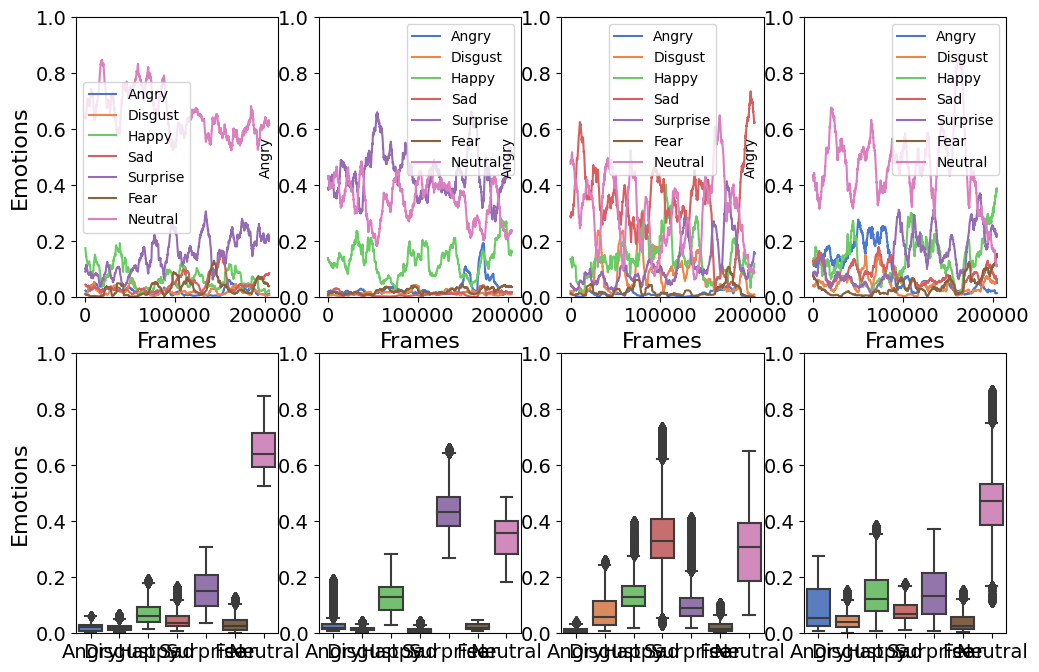

In [31]:
class_ids = pre_df['ClassID'].unique()

# Create a custom color palette
palette = sns.color_palette("muted", n_colors=len(emotions))

# Set font sizes
title_font_size = 16
label_font_size = 16
tick_font_size = 14

# Create a 2xN grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))

for i, cid in enumerate(class_ids):
    group = pre_df[pre_df['ClassID'] == cid]

    # Emotions over time plot (upper half)
    ax1 = axs[0, i]
    for emotion, color in zip(emotions, palette):
        sns.lineplot(data=group, x="Frame", y=emotion, ax=ax1, color=color, label=emotion)
    
    ax1.set_xlabel("Frames", fontsize=label_font_size)
    ax1.tick_params(axis='both', which='major', labelsize=tick_font_size)
    if i == 0:
        ax1.set_ylabel("Emotions", fontsize=label_font_size)
    ax1.set_ylim(0, 1)

    # Emotion magnitude plot (lower half)
    ax2 = axs[1, i]
    subset = pre_df[pre_df['ClassID'] == cid][emotions]
    sns.boxplot(data=subset, ax=ax2, palette=palette)

    ax2.tick_params(axis='both', which='major', labelsize=tick_font_size)
    if i == 0:
        ax2.set_ylabel("Emotions", fontsize=label_font_size)
    ax2.set_ylim(0, 1)

plt.show()

